In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Импортируем нужные библиотеки

#### Считывание и обработка данных

In [177]:
df = pd.read_excel("200_выпусков_'О_мой_питч!'_OutOfScope_update.xlsx", sheet_name='Лист2')
df = df.rename(columns={'Инвестиции' : 'Инвестиции(руб)', 'Без' : 'Воздержалось'})
df['За'] = pd.to_numeric(df['За'], errors='coerce')
df['Против'] = pd.to_numeric(df['Против'], errors='coerce')
df['Воздержалось'] = pd.to_numeric(df['Воздержалось'], errors='coerce')
df['Инвестиции(руб)'] = df['Инвестиции(руб)'].replace(0, np.nan)
df = df.drop(columns='№')
df = df.drop(index=82) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop(index=176) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop_duplicates(subset='Название')
pd.set_option('display.max_colwidth', None)  # 150 означает ограничение на кол-во символов в колонке "Описание"

#### Основные метрики по инвестициям и голосам в опросах

In [178]:
# Форматируем вывод чисел (два знака для float, целые для int)
pd.options.display.float_format = '{:,.2f}'.format
description = df[['Инвестиции(руб)', 'За', 'Против', 'Воздержалось', 'Всего']].describe()
description['Инвестиции(руб)'] = (description['Инвестиции(руб)'] / 1_000_000).round(2)
description[['За', 'Против', 'Воздержалось', 'Всего']] = description[['За', 'Против', 'Воздержалось', 'Всего']].astype(int)
description.rename(columns={'Инвестиции(руб)': 'Инвестиции (млн, руб)'}, inplace=True)
description_selected = description.loc[['mean', '25%', '50%', '75%', 'min', 'max']]
description_renamed = description_selected.rename(index={
    'mean': 'Среднее',
    '25%': '25-й перцентиль',
    '50%': 'Медиана (50-й перцентиль)',
    '75%': '75-й перцентиль',
    'min': 'Минимум',
    'max': 'Максимум'
})
description_renamed

,"Инвестиции (млн, руб)",За,Против,Воздержалось,Всего
Среднее,54.95,149,202,134,444
25-й перцентиль,11.81,95,132,101,357
Медиана (50-й перцентиль),27.00,128,175,131,435
75-й перцентиль,45.00,184,248,155,526
Минимум,0.08,35,43,61,182
Максимум,900.00,519,520,385,735


После пересмотра стартапов, где запрашиваемые инвестиции были 0, выяснилось, что на самом деле у таких стартапов просто нет информации по запрашиваемым инвестициям, поэтому все нули были заменены на NaN.  

### Разбивка стартапов по группам

In [179]:
keywords = {
    'Telegram' : ['телеграм', 'telegram', 'бот'],
    'Взаимоотношения' : [ 'познакомиться', 'знакомств', 'отношени', 'свидани', 'коммуникаци', 'скандал'],
    'AI_помощники' : ['виртуальн', 'помощник', 'ai', 'искусственн', 'интелект', 'ии', 'progpt','нейросет'], # proGPT нужен лишь для одного стартапа который относится к ИИ
    'Маркетинг_и_реклама' : ['реклам', 'маркетинг', 'продвижение', 'целевая аудитор', 'привлечен'],
    'B2B' : ['b2b', 'бизнес'],
    'Медицина' : ['профилактик', 'медицин', 'врач', 'докт', 'хирург ', 'маломобильных', 'процедур','здоровь', 'вирус', 'анализы', 'психолог', 'таблет', 'больн', 'узи', 'заболевани', 'фармацевт'],
    'Образование': ['студент', 'университет', 'школ', 'образован', 'универ', 'экзамен', 'общежит', 'образован', 'английск', 'иностранн', 'образовательн', 'school'],
    'Спорт': ['тренировк', 'фитнес', 'физкультур', 'атлетик', 'кардио', 'нагруз', 'сорев', 'экипиров', 'упражнен'],
    'Сервисы_доставки': [ 'курьер', 'доставк', 'груз', 'логистик', 'маршрут', 'навигатор'],
    'Путешествия': ['поездк', 'туризм', 'путешеств', 'путевк', 'экскурси', 'курорт', 'проживание', 'travel'],
    'Еда': ['кухн', 'повар', 'еда', 'пищ', 'рецепт', 'ингредиент', 'блюд', 'еды', 'общепит', 'едой'],
    'Автомобили_и_транспорт' : ['машина', 'техобслуж', 'кузов', 'транспорт','автомобил', 'двигател', 'автовладел', 'автозапчаст', 'машины'],
    'Финтех' : ['крипто', 'валюта', 'трейд', 'инвестици', 'блокчейн', 'страховани', 'кредит', 'банкинг', 'платежн'],
    'Маркетплейсы' : ['маркетплейс'],
}
def categorize(description):
    matched_words = {category: [] for category in keywords}  # Словарь для хранения всех ключевых слов по категориям
    words_in_description = description.lower().split()  # Разбиваем описание на слова
    for category, words in keywords.items():
        for word in words_in_description:
            for keyword in words:
                if word.startswith(keyword):
                    if keyword not in matched_words[category]:
                        matched_words[category].append(keyword)
                    return category, matched_words  # Возвращаем первую найденную категорию
    return 'Прочее', matched_words  # Если категории не найдены

def categorize_with_words(description):
    category, words = categorize(description)
    # Формируем строку из всех ключевых слов для найденной категории
    all_keywords = words.get(category, [])
    keywords_str = ', '.join(all_keywords)
    return pd.Series([category, keywords_str])

# Применяем обновлённую функцию к DataFrame
df[['Категория', 'Ключевые слова']] = df['Описание'].apply(categorize_with_words)


Разбивка работает по принципу поиска ключевого слова (начала ключегого слова) в описании стартапа



#### Определение групп



- **Telegram** - к группе относятся стартапы, в которых основным продуктом является телеграм-бот либо сервис по работе с приложениями внутри телеграма

- **Взаимоотношения** - группа стартапов, в которых сосредоточены приложения для знакомств, семейные психологи  

- **AI_помощники** - стартапы с помощниками на искусственном интеллекте, которые выполняют самые разные задачи, от консультации по тренировкам до помощи в разработке приложений  

- **Маркетинг_и_реклама** - группа содержит стартапы, которые предоставляют различные услуги продвижения малым, средним, крупным бизнесам, а также стартапы, которые направлены на удовлетворение нужд и потребностей пользователей посредством обмена  
- **B2B** -  стартапы, которые помогают бизнесам развиваться (различные конструкторы, платформы и другое)  
- **Медицина** - различные девайсы для защиты здоровья, также имеются сервисы с AI, которые помогают врачам в разных областях проводить сложные операции  
- **Образование** - онлайн-школы, различные сервисы для студентов и школьников, сервисы по изучению иностранных языков 
- **Спорт** - приложения, которые составляют план тренировок, фитнес-трекеры
- **Сервисы_доставки** - сервисы/приложения/боты по доставке продуктов или вещей
- **Путешествия** - cтартапы из этой группы помогают найти дом, который будет наиболее подходящим, также есть сервисы для создания персонального плана путешествий  
- **Автомобили_и_транспорт** - в эту группу попали стартапы, которые нацелены на помощь водителям, механикам, и другим людям, которые работают в сфере транспорта
- **Финтех** - в группу входят стартапы по созданию криптовалютных кошельков, серсвисы трейдинга, блокчейн, платформы-помощники по получению кредита
- **Еда** - сервисы для помощи приготовления еды, поиска поваров, рецептов, доставки еды
- **Маркетплейсы** - группа содержит стартапы, главным продуктом которых является маркетплейс, либо "программа" (бот, AI), которая помогает работать с маркетплейсом
- **Прочее** - в эту группу попали стартапы, которые не попали ни в одну из вышеперечисленных групп
   


#### Примеры случайных стартапов из каждой группы


In [180]:
def get_random_startup_by_category(df, columns_to_display):
    random_startups = []
    grouped = df.groupby('Категория') 
    for category, group in grouped:
        random_startup = group.sample(1)  
        random_startups.append(random_startup)
    result_df = pd.concat(random_startups)
    return result_df[columns_to_display]

columns_to_display = ['Название', 'Описание', 'Категория', 'Ключевые слова']
random_startups_df = get_random_startup_by_category(df, columns_to_display)
pd.set_option('display.max_rows', None)
random_startups_df

,Название,Описание,Категория,Ключевые слова
132,ScAInet,"Система поиска утечек в сетях водоснабжения с помощью искусственного интеллекта и датчиков собственной разработки. На текущий момент до 40% воды являются безвозвратными потерями из-за износа сетей. На примере Мосводоканала в год потери составляют 20-30 млрд руб. Объём рынка подобного оборудования в России 6-7 млрд руб. Нами проведён успешный пилот в Уфаводоканал, сейчас договорились о пилоте с Мосводоканалом. Инвестиции нужны для запуска производства датчиков.",AI_помощники,искусственн
47,Rebel,"Приложение для покупки, продажи и хранения ценных бумаг малого, среднего и крупного бизнеса. Основной плюс — нет никаких посредников, вроде брокеров, андеррайтеров.",B2B,бизнес
120,WishBot,"Бот-желаний в Telegram - сервис помощи дарителям и получателям подарков. С помощью анализа данных о желаниях пользователей и выдачи предложений об интернет-магазине, где можно совершить покупку подарка - позволяет значительно повысить эффективность таргетированной рекламы и конверсию в реальных покупателей.",Telegram,бот
126,Numpass,"Уведомления для автовладельцев при помехе без звонков, переписок и номера телефона. Платежи на парковках без паркоматов, платные трассы без очередей и заправки без касс.",Автомобили_и_транспорт,автовладел
194,DataFuel,DataFuel — платформа для персонализации коммуникаций на основе психографики и BigData. Мы помогаем повышать продажи CRM-маркетинга и колл-центров с помощью персонализации контента под тип личности клиента.,Взаимоотношения,коммуникаци
199,Housecook,"Парни сделали улучшенную версию не взлетевшего сервиса Uber Chief. Там повар приезжал лично, в Housecook с поваром вы общаетесь по видео и аудиосвязи. Схема такая: покупаете продукты по списку, звоните шеф-повару, и он помогает вам готовить. \n\nПользователь получает крутое блюдо и новые знания, повара — деньги за консультацию и возможность раскрутить свой личный бренд, сервис зарабатывает на комиссии. Сейчас в базе сервиса уже 300 поваров.",Еда,повар
98,Rukki.pro,"Сервис для поиска любой спецтехники. Иногда неделями нужно искать адекватного исполнителя, потратив бюджет на ремонт на телефонные переговоры. Но то было раньше, а теперь появился сервис — Rukki.pro. У нас в команде не просто классные пацаны, а конкретно заточенные на превосходный клиентский сервис профессионалы из бизнеса, маркетинга, строительства и логистики.\n\nСегодня у нас 829 заказчиков, 566 исполнителей, 926 заказов, 894 единиц спецтехники и вполне адекватное приложение для Андроид (потому что их больше). Наши продажи показывают, что на одном заказе мы зарабатываем от 7% до 15% комиссии. А еще есть рефералка для партнеров и юридическая помощь для ""кинутых"". Сейчас мы привлекаем посевной раунд $300k по оценке $2м. А через 18 месяцев, если все пойдет как планируем — будем поднимать Раунд-A по оценке $10м.",Маркетинг_и_реклама,маркетинг
186,SlideLab,"Сервис для разработки презентаций и работы с ними. Совмещает в себе эффективный редактор с фокусом на производительность рабочего процесса, облачную платформу для хранения данных и маркетплейс с профессиональными шаблонами презентаций. Сервис позволяет работать с презентациями как в приложении, так и в браузере. Данные синхронизируются в реальном времени, что позволяет, в том числе, вести коллективную разработку проектов.",Маркетплейсы,маркетплейс
70,Meteoagent,"Мобильное приложение для метеозависимых людей. Приложение бережет здоровье, заранее предупреждая о резких изменениях погоды и позволяя вести дневник самочувствия для людей с метеозавиcимостью.",Медицина,здоровь
81,Amazy,Amazy помогает преподавателям иностранных языков создавать и продавать учебные материалы онлайн,Образование,иностранн


#### Количество стартапов в отдельно выбранной категории

In [187]:
df[df['Категория'].str.contains('Telegram', na=False)]

,Название,Описание,Сайт,Инвестиции(руб),За,Против,Воздержалось,Всего,Дата,Категория,Ключевые слова
2,Thx loyalty,"Thx loyalty — конструктор Telegram-приложений. Сервис позволяет создать свое приложение для бизнеса в сферах HoReCa, e-commerce, услуг. Выстроить коммуникацию и автоматизировать работу с клиентами",https://thx-loyalty.com/,"16,000,000.00",114,124,143.00,381,2024-05-30,Telegram,telegram
10,Grepdrop,"Grepdrop позволяет автоматически мониторить чаты и каналы в Telegram и искать в них сообщения с определенными ключевыми словами, от определенных пользователей и так далее. Вот здесь (https://t.me/Read_more_do_less) можно почитать больше технических подробностей",https://grepdrop.com/,NaN,90,151,147.00,388,2024-04-04,Telegram,telegram
12,Uniton.ai,"Приложение внутри Telegram, которое агрегирует все каналы, с помощью ИИ выбирает самые подходящие посты под каждого пользователя и выдает их в персональную умную ленту. Схоже с Твитером и запрещенном в России Инстаграмом",https://www.uniton.ai/,"90,000,000.00",129,302,214.00,645,2024-03-21,Telegram,telegram
76,Waka,"Waka - это геймифицированные знакомства для поколения Z. Стоит понимать, что waka - это мини-приложение внутри мессенджера Telegram. Оно работает в связке: веб-приложение (в котором и происходит вся геймификация) + бот в мессенджере (для авторизации и пуш-нотификаций). \n\nWaka ― для зумеров, которые ищут не только любовную переписку, а простое дружеское общение, компанию для походов в кино, для тех, кто хочет найти члена для своей геймерской тимы или просто человека со схожим чувством юмора.",https://waka.cool/,"45,000,000.00",109,227,172.00,508,2022-09-08,Telegram,telegram
86,Finpanda,"Платформа для проведения IPO инфлюенсеров и инвестиций в Telegram-каналы, где базовым активом является цифровой рекламный контракт, цена которого привязана к количеству аудитории медиа-канала. Контракт можно хранить на балансе или перепродавать на бирже и передавать право на рекламную публикацию.",https://finpanda.co/,"220,000,000.00",109,156,143.00,408,2022-01-27,Telegram,telegram
103,МАША (DeepVoice),"Маша — телеграм-бот, цифровой секретарь, ответит и отфильтрует ваши телефонные звонки, когда вы заняты. Если вы не уверены, кто вам звонит и зачем, вы можете отклонить входящий звонок, и Маша его обработает. Маша работает с любыми операторами связи. Поговорит вместо вас, спросит кто звонит, и зачем. Вы получите расшифровку звонка и аудиофайл о том, кто вам звонил и что хотел. На основании этой информации вы поймете контекст обращения, сможете отметить звонок как спам или поставить себе напоминание о том, что необходимо связаться с тем, кто вас беспокоил.",https://deepvoice.ru/,"7,500,000.00",245,143,114.00,502,2021-08-05,Telegram,телеграм
120,WishBot,"Бот-желаний в Telegram - сервис помощи дарителям и получателям подарков. С помощью анализа данных о желаниях пользователей и выдачи предложений об интернет-магазине, где можно совершить покупку подарка - позволяет значительно повысить эффективность таргетированной рекламы и конверсию в реальных покупателей.",https://t.me/Wishgift_bot,"5,000,000.00",58,182,113.00,353,2021-04-01,Telegram,бот
152,Billy,"Бот для корпоративных мессенджеров Slack и Microsoft Teams для повышения мотивации персонала и аналитики поведения сотрудников. Бот позволяет выпустить командную валюту, которая может использоваться для p2p благодарностей в мессенджере, системах отслеживания задач (Jira, Trello) и на Github. На основе взаимодействий бот строит аналитику по активности сотрудников, подсказывает менеджерам о возможных проблемах с выгоранием и выявляет собирающихся увольняться.",https://iambilly.app/,"10,000,000.00",194,368,NaN,562,2020-08-07,Telegram,бот
153,Clean Traffic,"Комплексное решение по оптимизации рекламных расходов в web-среде. Сервис детектирует ботов и нецелевой трафик, имеет возможность блокировки такого трафика, предоставляет отчеты о качестве трафика с разделением по источникам, даёт рекомендации по борьбе с ботами.\n\nКроме этого Clean Traffic

#### Количество стартапов по категориям

In [182]:
def count_subcategory_occurrences(df, subcategories):
    categories = df['Категория'].str.split(', ', expand=True)
    categories = categories.melt(value_name='Категория').dropna()['Категория']
    results = []
    for subcategory in subcategories:
        count = categories[categories.str.contains(subcategory, case=True)].count()
        results.append((subcategory, count))
    result_df = pd.DataFrame(results, columns=['Категория', 'Количество'])
    result_df = result_df.sort_values(by='Количество', ascending=False).reset_index(drop=True)
    return result_df
subcategories_list = ['Прочее', 'Telegram', 'B2B', 'Взаимоотношения', 'AI_помощники', 'Маркетплейсы', 'Финтех', 'Автомобили_и_транспорт', 'Медицина', 'Спорт', 'Сервисы_доставки', 'Путешествия', 'Еда', 'Образование', 'Маркетинг_и_реклама']
subcategory_counts_df = count_subcategory_occurrences(df, subcategories_list)
subcategory_counts_df

,Категория,Количество
0,Прочее,45
1,AI_помощники,34
2,B2B,16
3,Медицина,14
4,Маркетинг_и_реклама,13
5,Telegram,11
6,Финтех,11
7,Сервисы_доставки,11
8,Образование,8
9,Автомобили_и_транспорт,7


#### Визуализируем данные

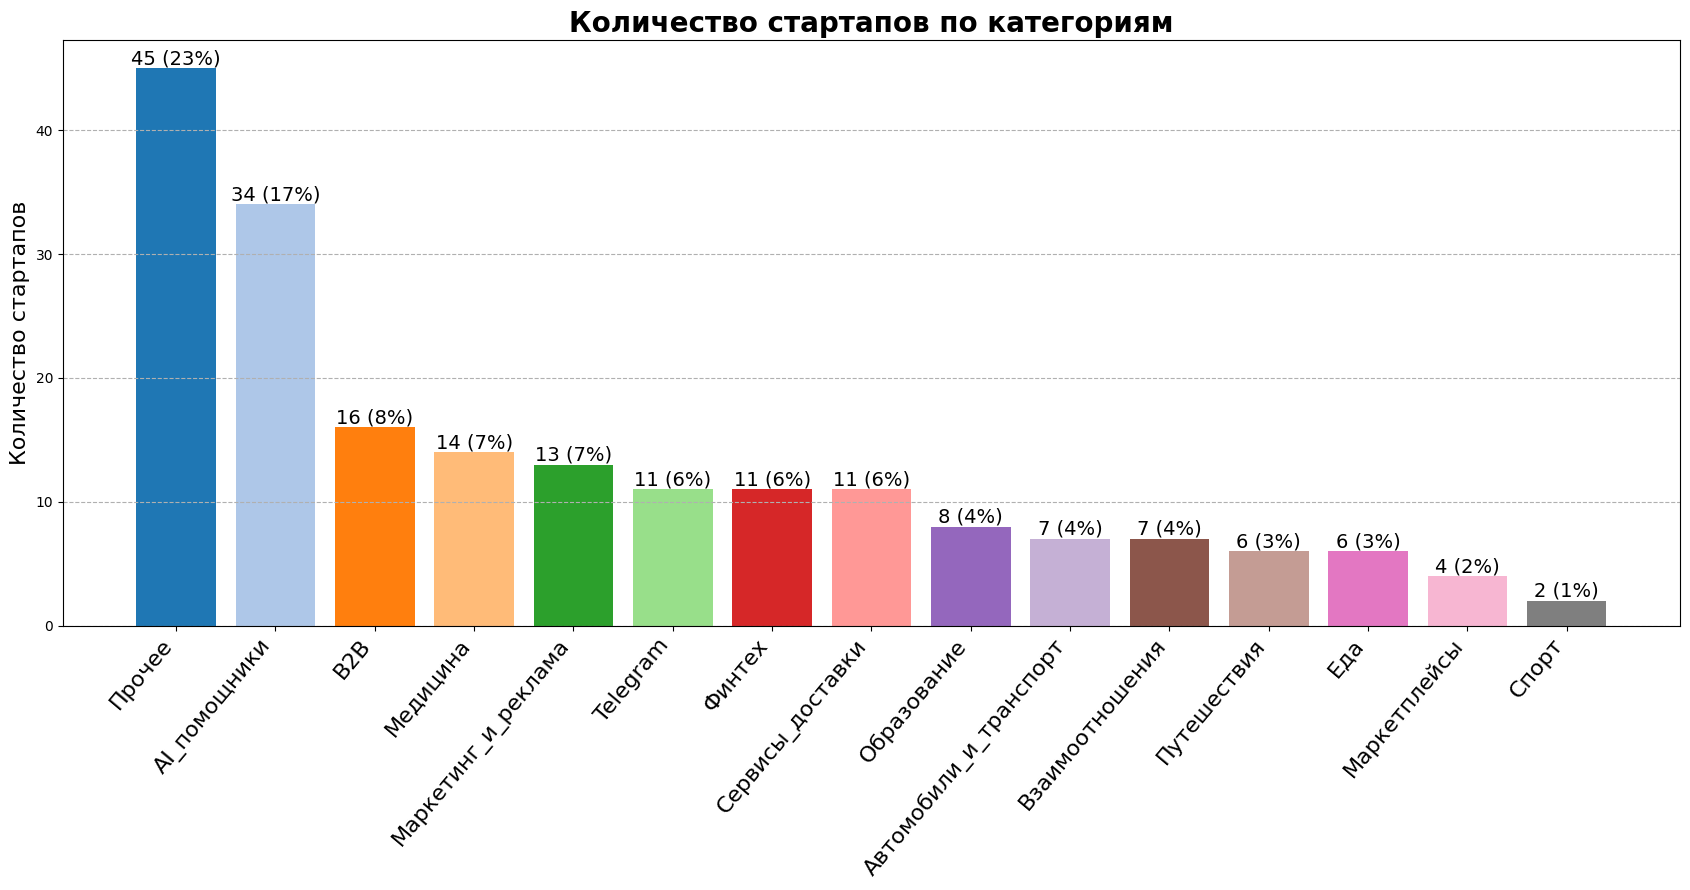

In [183]:
category_labels = subcategory_counts_df['Категория']
category_counts = subcategory_counts_df['Количество']
colors = plt.get_cmap('tab20').colors
total_counts = df.shape[0]
plt.figure(figsize=(17, 9))
bars = plt.bar(
    category_labels, 
    category_counts, 
    color=colors[:len(category_labels)]
)
plt.title('Количество стартапов по категориям', fontsize=20, fontweight='bold')
plt.ylabel('Количество стартапов', fontsize=16)
plt.xticks(rotation=50, fontsize=16, ha='right')  # Поворот меток категорий, если они длинные
plt.grid(axis='y', linestyle='--')  # Сетка по вертикальной оси
plt.tight_layout()  # Подгонка для отображения меток
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    # Рассчитываем процент
    percent = count / total_counts * 100
    # Отображаем количество и процент на графике
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{count} ({percent:.0f}%)', 
        ha='center', 
        va='bottom', 
        fontsize=14
    )
plt.show()



Видим, что распределение по заданным (предполагаемым) группам в основном сосредоточилось на маркетинге, рекламе и AI помощниках.

Это может быть связано с тем, что в настоящее время цифровые технологии применяются в любой области, что потверждается данными из массива уникальных подгрупп, почти в каждой из которых есть либо маркетинг с рекламой, либо AI

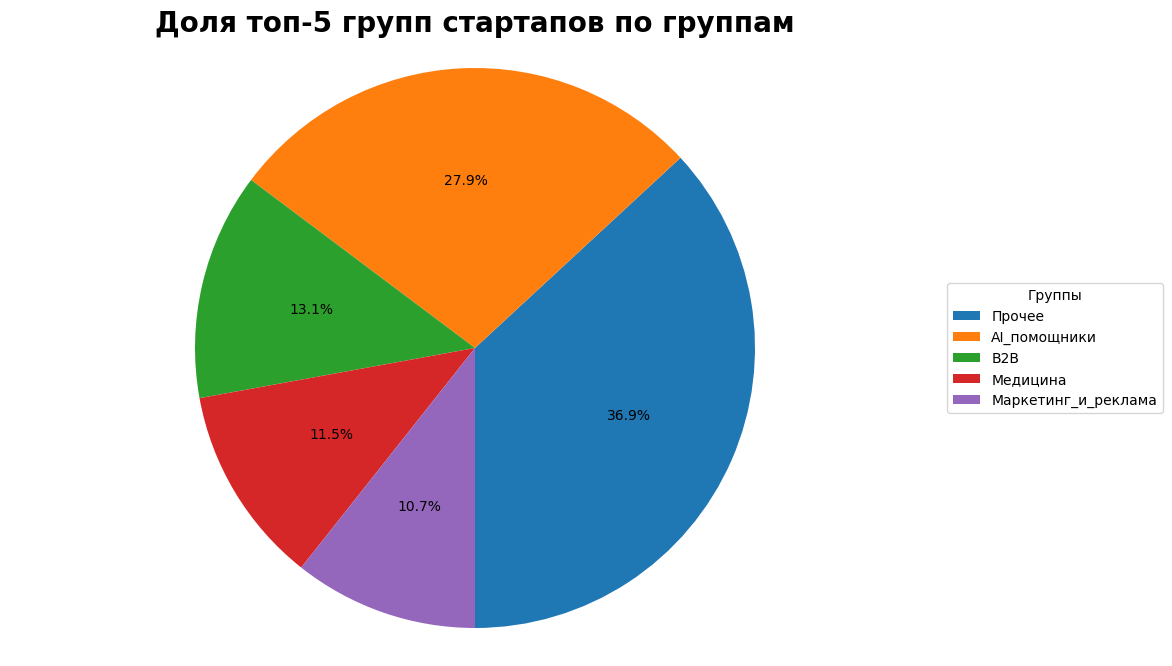

In [184]:
# Список категорий, которые нужно отобразить
categories_to_display = ['AI_помощники', 'B2B', 'Медицина', 'Маркетинг_и_реклама', 'Прочее']  # Замените на нужные категории

# Получаем категории и количество из DataFrame (как Series)
category_labels = subcategory_counts_df['Категория']
category_counts = subcategory_counts_df['Количество']

# Фильтруем данные по категориям, которые нужно отобразить
filtered_df = subcategory_counts_df[subcategory_counts_df['Категория'].isin(categories_to_display)]

# Обновляем переменные с отфильтрованными данными
filtered_labels = filtered_df['Категория']
filtered_counts = filtered_df['Количество']

# Настраиваем цвета для диаграммы
colors = plt.get_cmap('tab10').colors

# Создаём диаграмму
plt.figure(figsize=(12, 8))
plt.pie(
    filtered_counts,
    autopct='%1.1f%%',
    colors=colors[:len(filtered_labels)],
    startangle=-90
)

# Добавляем легенду и настраиваем оформление
plt.legend(
    filtered_labels,
    title="Группы",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Доля топ-5 групп стартапов по группам', fontsize=20, fontweight='bold')
plt.axis('equal')  # Оформление диаграммы в круг
plt.show()




Заметим, что AI помощники ненамного макретинг и рекламу. Это связано с быстрым развитием искуственного интеллекта, поэтому сейчас все больше команд так или иначе используют AI в своих стартапах.

Логистические стартапы в свою очередь отстают от медицинских стартапов. Это можно объяснить тем, что в современном мире появилось очень много новых логистических услуг. Доставка продуктов из магазина, еды из ресторана, грузоперевозки от небольших шкафов до жилых домов. Все это является причиной достаточно большой доли логистических стартапов

Также стоит отметить, что чуть меньшн четверти всех проектов либо не попала ни в одну из категорий, либо же процент от общего числа составлял меньше 10 %  
Проанализировав эту категорию, можно сделать вывод, что в ней сосредоточились стартапы, которые либо "уникальны" в своем роде и их нельзя объединить с другими стартапами, либо категория будет настолько мала, что добавлять ее в список существующих нецелесообразно


#### Стартапы из группы "Прочее"

In [185]:
df[df['Категория'].str.contains('Прочее', na=False)]


,Название,Описание,Сайт,Инвестиции(руб),За,Против,Воздержалось,Всего,Дата,Категория,Ключевые слова
13,Дом без забот,"«Дом без забот» - это сервис, который связывает специалистов (сантехников, электриков, сборщиков мебели и так далее) с их клиентами. Проект за 4 года работы уже показал высокий спрос со стороны потребителей. Сейчас на сервисе 275 000 специалистов по всей России",https://dombezzabot.info/,"50,000,000.00",235,146,164.00,545,2024-03-14,Прочее,
14,Dialext,"Dialext — сервис, который позволяет увеличивать конверсию в продажи за счет автоматического аудита телефонных переговоров. Он позволяет выявить и исправить ошибки ваших продажников",https://dialext.com/,"6,000,000.00",106,113,125.00,344,2024-02-22,Прочее,
20,SmartAim,"SmartAim — система визуального поиска,\nадресной регистрации и навигации объектов для складов. Она помогает кладовщику с быстрым поиском необходимого адреса. Сотрудник склада безошибочно, по подсказке - световому лучу, двигается к нужному месту на складе, не смотря в монитор ТСД или визуально сверяясь с множеством меток адресного хранения.",-,"20,000,000.00",97,98,137.00,332,2023-12-28,Прочее,
24,Advengene,"Advengene - поиск подтверждения национальности предков для получения гражданства Израиля, Германии, Польши, Латвии, Эстонии, Литвы, Финляндии по репатриации",https://advengene.com/,NaN,124,182,177.00,483,2023-11-30,Прочее,
25,Brainbox.vc,"Brainbox.VC – краудинвестинговая платформа в РФ (лицензия Банка России №77). Строим площадку, на которой IT-стартапы на ранней стадии смогут найти (1) инвесторов, (2) специалистов. Саму платформу развивает сообщество brainbox.team и сейчас мы ищем новых участников сообщества, которые готовы финансировать проект, купив его акции.",https://brainbox.vc/,"50,000,000.00",136,246,186.00,568,2023-11-23,Прочее,
26,ieye,"ieye — приложение, которое позволяет быстро и точно находить нужные заведения (бары, рестораны, ночные клубы и так далее). При этом можно узнать, сколько там посетителей, есть ли там друзья и знакомые, какие скидки и предложения действуют",http://ieye.io/,"180,000,000.00",95,330,176.00,601,2023-11-16,Прочее,
31,TapTable,"Tap Table — это легкое и быстрое приложение для онлайн-бронирования столиков в кафе, ресторанах и барах, а также удобная админ-панель для ресторана. Сейчас мы запустились в трех городах Краснодарского края ( Краснодар, Сочи, Геленджик). Только в Краснодаре с июня к сервису подключились 50 ресторанов. Мы бур",https://taptable.ru/,"36,000,000.00",117,245,132.00,494,2023-10-12,Прочее,
32,Paraliq,Инфраструктура и White Label решения для создания децентрализованных казино в один клик,http://paraliq.com/,"90,000,000.00",117,178,113.00,408,2023-09-28,Прочее,
34,Liberty Card,Сервис дистанционного оформления зарубежных карт Visa и Mastercard,https://libertycard.ru/,"500,000.00",129,203,125.00,457,2023-09-14,Прочее,
40,Вручалка,"Вручалка — сервис заказа подарков и услуг торжественного вручения. Через него можно выбрать, а затем вручить подарок друзьям, родственникам или знакомым в другом городе или стране. Сервис запустили в 2021-м, а сейчас развивают франшизу и собираются выходить на международный рынок.",https://vruchalka.com/,"50,000,000.00",84,232,135.00,451,2023-07-27,Прочее,


Группа HR не будет актуальной, т.к. содержит малое коичество стартапов  

В эту группу бы попали: 'Дом без забот', 'Kwikwins', 